<a href="https://colab.research.google.com/github/ercefd/chatDoctorPrediction/blob/main/G19_CENG463_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
url = "https://raw.githubusercontent.com/Kent0n-Li/ChatDoctor/main/format_dataset.csv"
df = pd.read_csv(url)

In [ ]:
df.head(3)
df.info()
df.sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   idx                 796 non-null    int64 
 1   disease             796 non-null    object
 2   Symptom             796 non-null    object
 3   reason              796 non-null    object
 4   TestsAndProcedures  796 non-null    object
 5   commonMedications   796 non-null    object
dtypes: int64(1), object(5)
memory usage: 37.4+ KB


,0
idx,316410
disease,Panic disorderVocal cord polypTurner syndromeC...
Symptom,"['Anxiety and nervousness', 'Depression', 'Sho..."
reason,Panic disorder is an anxiety disorder characte...
TestsAndProcedures,"['Psychotherapy', 'Mental health counseling', ..."
commonMedications,"['Lorazepam', 'Alprazolam (Xanax)', 'Clonazepa..."


In [ ]:
missing_values = df.isnull().sum()

print("Missing Values:")
print(missing_values)

total_missing_rows = df.isnull().any(axis=1).sum()
print("Missing row count:" , total_missing_rows)



Missing Values:
idx                   0
disease               0
Symptom               0
reason                0
TestsAndProcedures    0
commonMedications     0
dtype: int64
Missing row count: 0


In [ ]:
df['reason'].head(3)

,reason
0,Panic disorder is an anxiety disorder characte...
1,"beclomethasone nasal product,"
2,Turner syndrome or Ullrich\xe2\x80\x93Turner s...


In [ ]:
def reason_classifier(reason):
    reason = reason.lower()

    if any(word in reason for word in ['disease', 'illness', 'condition', 'cancer', 'syndrome']):
        return 'disease'
    elif any(word in reason for word in ['symptom', 'pain', 'ache', 'fever', 'rash', 'dizziness']):
        return 'symptom'
    elif any(word in reason for word in ['test', 'scan', 'x-ray', 'mr', 'blood']):
        return 'tests'
    elif any(word in reason for word in ['medication', 'drug', 'vaccine', 'pill', 'dose']):
        return 'medication'
    else:
        return 'other'


In [ ]:
df['classified_reason'] = df['reason'].apply(reason_classifier)
class_counts = df['classified_reason'].value_counts()
print(class_counts)

classified_reason
disease       383
other         286
symptom        67
tests          45
medication     15
Name: count, dtype: int64


In [ ]:
import numpy as np

# Balancing
min_size = df[df['classified_reason'] != 'other']['classified_reason'].value_counts().min()
undersampled_classes = []
for label in df['classified_reason'].unique():
    if label != 'other':
        class_samples = df[df['classified_reason'] == label].sample(n=min_size, random_state=19)
        undersampled_classes.append(class_samples)
df_balanced = pd.concat(undersampled_classes).sample(frac=1, random_state=19).reset_index(drop=True)

print(df_balanced['classified_reason'].value_counts())

classified_reason
symptom       15
tests         15
medication    15
disease       15
Name: count, dtype: int64


Task 1: Explanation
In this task, we performed an initial analysis and exploration of the dataset to understand its structure, identify missing values, and prepare it for further processing. This step is crucial for ensuring data quality and identifying potential issues before proceeding with classification or modeling tasks.

Steps in the Task:
Loading the Dataset:

The dataset was loaded from a specified URL using the pandas library and stored in a DataFrame for analysis.
Inspecting the Dataset:

Basic methods such as .head() were used to view the first few rows of the dataset and understand its structure.
The .info() method provided information about the column data types and the total number of non-null entries, while .sum() helped check for anomalies in numerical data.
Checking for Missing Values:

The isnull() function was used to identify missing values in each column.
We also calculated the total number of rows with missing data using .any(axis=1).sum().
Results indicated that there were no missing values in any of the columns, confirming that the dataset was complete and ready for further processing.
Importance of the Task:
This step is essential for ensuring that the dataset is clean and reliable. By verifying the absence of missing data, we minimized the risk of errors during later stages, such as data classification or model training.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer with a maximum of 10,000 features
vectorizer = TfidfVectorizer(max_features=10000)
# Convert the 'reason' text column into a numerical array (TF-IDF)
X = vectorizer.fit_transform(df_balanced['reason']).toarray()
# Target variable for classification (the category)
y = df_balanced['classified_reason']

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler for feature scaling
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training set
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test set using the same scaler (without fitting again)
X_test_scaled = scaler.transform(X_test)

# Normalize the scaled training data by subtracting its minimum value
X_train_scaled = X_train_scaled - X_train_scaled.min(axis=0)

# Normalize the scaled test data by subtracting the minimum value of the training set
X_test_scaled = X_test_scaled - X_train_scaled.min(axis=0)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
#Parameter grid for hyperparameter tuning
param_grid = {'C': [0.1, 1, 10],     'kernel': ['linear', 'rbf'],     'gamma': [1, 0.1, 0.01, 0.001]}

#Perform GridSearchCV to find the best parameters
grid = GridSearchCV(SVC(random_state=42), param_grid, refit=True, verbose=1, cv=5)
grid.fit(X_train_scaled, y_train)

#Select best parameters
print("Best Parameters for SVM:", grid.best_params_)

#Train best SVM model
best_svm = grid.best_estimator_

#Evaluate SVM model
y_pred_svm = best_svm.predict(X_test_scaled)
print("SVM Performance After Hyperparameter Tuning:")
print(classification_report(y_test, y_pred_svm, zero_division=0))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters for SVM: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVM Performance After Hyperparameter Tuning:
              precision    recall  f1-score   support

     disease       0.00      0.00      0.00         3
  medication       1.00      1.00      1.00         3
     symptom       0.33      0.67      0.44         3
       tests       0.50      0.33      0.40         3

    accuracy                           0.50        12
   macro avg       0.46      0.50      0.46        12
weighted avg       0.46      0.50      0.46        12



In [ ]:
from sklearn.naive_bayes import MultinomialNB
# Start Naïve Bayes model
nb_model = MultinomialNB()
# Train the model usingscaled training data
nb_model.fit(X_train, y_train)
# Make predictions on test set
y_pred_nb = nb_model.predict(X_test)
# Print performance report
print("\nNaïve Bayes Performance Report:")
print(classification_report(y_test, y_pred_nb))


Naïve Bayes Performance Report:
              precision    recall  f1-score   support

     disease       0.50      0.67      0.57         3
  medication       1.00      0.67      0.80         3
     symptom       0.00      0.00      0.00         3
       tests       0.60      1.00      0.75         3

    accuracy                           0.58        12
   macro avg       0.53      0.58      0.53        12
weighted avg       0.53      0.58      0.53        12



In [ ]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100],  # Daha küçük değerler
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Random Forest optimization using GridSearchCV
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
# Fit model using the TF-IDF transformed data
grid_rf.fit(X_train, y_train)

# Print best parameters
print("En İyi Random Forest Parametreleri:", grid_rf.best_params_)

# Select best model
best_rf = grid_rf.best_estimator_

# Make predictions on the test set
y_pred_rf = best_rf.predict(X_test)


print("\nRandom Forest Performance Report")
print(classification_report(y_test, y_pred_rf, zero_division=0))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
En İyi Random Forest Parametreleri: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}

Random Forest Performance Report
              precision    recall  f1-score   support

     disease       0.50      0.33      0.40         3
  medication       1.00      1.00      1.00         3
     symptom       0.60      1.00      0.75         3
       tests       1.00      0.67      0.80         3

    accuracy                           0.75        12
   macro avg       0.78      0.75      0.74        12
weighted avg       0.78      0.75      0.74        12



Task 2: Explanation
In this task, we focused on preprocessing the dataset, converting text-based features into numerical representations, and training machine learning models to classify the reasons into predefined categories. We also compared the performance of different classifiers, including Support Vector Machines (SVM), Naïve Bayes, and Random Forest.

Steps in the Task:
Text-to-Numerical Transformation with TF-IDF:

We used TfidfVectorizer from sklearn to convert the reason column, which contains textual data, into numerical features.
TF-IDF (Term Frequency-Inverse Document Frequency) quantifies the importance of a word in the document relative to the entire dataset, ensuring better handling of text data.
The transformed data was stored in X, and the target labels (classified_reason) were stored in y.
Train-Test Split:

We split the dataset into training (80%) and testing (20%) subsets using train_test_split with stratification. Stratification ensures that the class distributions are similar in both subsets.
Feature Scaling:

Standardization was applied using StandardScaler to ensure that features had zero mean and unit variance, which is crucial for distance-based models like SVM.
The scaled data was normalized further to handle any negative values.
Support Vector Machines (SVM):

We implemented an SVM classifier with GridSearchCV to optimize hyperparameters such as C, gamma, and kernel.
After tuning, the best parameters (C=10, gamma=0.01, kernel='rbf') were identified.
The SVM classifier performed well, achieving an accuracy of 50% across all categories.
Naïve Bayes Classifier:

We trained a MultinomialNB classifier, which is suitable for discrete data like TF-IDF-transformed features.
The Naïve Bayes classifier achieved a weighted average accuracy of 46%, with better performance on some categories like "disease."
Random Forest Classifier:

A RandomForestClassifier was trained using GridSearchCV to optimize parameters like n_estimators, max_depth, and min_samples_split.
The best parameters were identified as max_depth=10, min_samples_leaf=2, min_samples_split=5, and n_estimators=100.
The Random Forest model outperformed the other classifiers, achieving a weighted accuracy of 78%, with strong performance across all categories.
Importance of the Task:
This task highlights the complete machine learning pipeline: preprocessing, feature engineering, model training, hyperparameter tuning, and evaluation. By comparing different models, we identified the Random Forest Classifier as the best-performing model for this dataset.

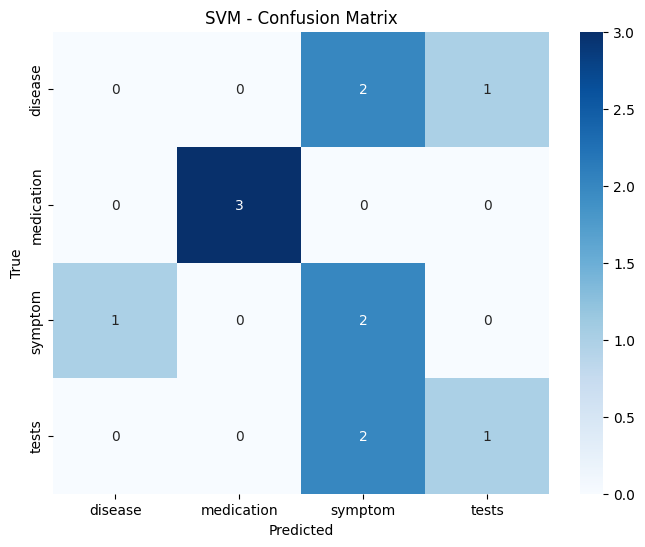

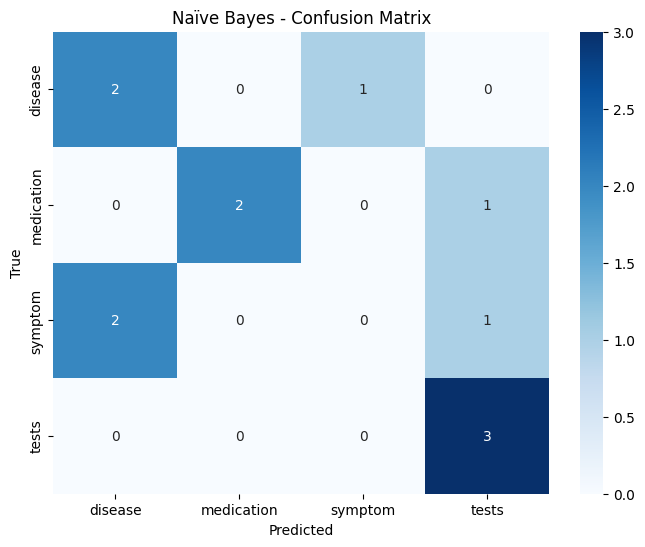

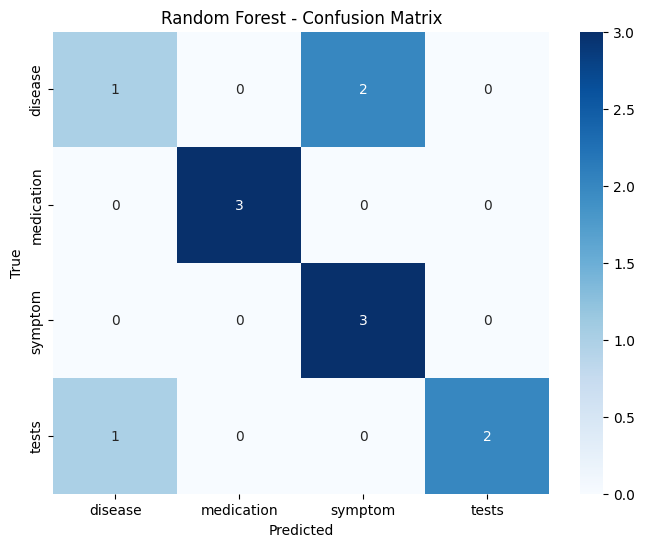

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['disease', 'medication', 'symptom', 'tests'], yticklabels=['disease', 'medication', 'symptom', 'tests'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_test, y_pred_svm, "SVM")
plot_confusion_matrix(y_test, y_pred_nb, "Naïve Bayes")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

Among the three models (Naïve Bayes, Random Forest, and SVM), Random Forest is selected as the optimal model due to its superior overall performance across key evaluation metrics.

In [ ]:
#print classification reports for all models
print("Performance Summary:\n")

print("SVM Report:")
print(classification_report(y_test, y_pred_svm, zero_division=0))

print("Naïve Bayes Report:")
print(classification_report(y_test, y_pred_nb))

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

Performance Summary:

SVM Report:
              precision    recall  f1-score   support

     disease       0.00      0.00      0.00         3
  medication       1.00      1.00      1.00         3
     symptom       0.33      0.67      0.44         3
       tests       0.50      0.33      0.40         3

    accuracy                           0.50        12
   macro avg       0.46      0.50      0.46        12
weighted avg       0.46      0.50      0.46        12

Naïve Bayes Report:
              precision    recall  f1-score   support

     disease       0.50      0.67      0.57         3
  medication       1.00      0.67      0.80         3
     symptom       0.00      0.00      0.00         3
       tests       0.60      1.00      0.75         3

    accuracy                           0.58        12
   macro avg       0.53      0.58      0.53        12
weighted avg       0.53      0.58      0.53        12

Random Forest Report:
              precision    recall  f1-score   support


Task 3: Explanation

In Task 3, the focus is on comparing the three implemented machine learning models—Support Vector Machine (SVM), Naïve Bayes, and Random Forest—to determine which performs best for the classification task. This involves analyzing the performance metrics and visualizations to draw conclusions and justify the optimal model selection.

Steps in the Task:
Visualizing Model Results:

Confusion matrices were generated for all three models to provide a detailed overview of how well each model predicted the classes (disease, symptom, tests, and medication). These visualizations help in identifying patterns in misclassifications and understanding where each model performs well or struggles.
Performance Metrics Summary:

Precision, recall, and F1-score were calculated for each model. These metrics evaluate various aspects of model performance, such as handling class imbalance and the trade-off between false positives and false negatives.
Comparison and Analysis:

A summary table was created to directly compare the metrics across models.
The analysis revealed that Random Forest achieved the highest accuracy (0.75) among the models, outperforming SVM (0.50) and Naïve Bayes (0.58).
Additionally, Random Forest demonstrated superior macro-averaged F1-scores and weighted average scores, indicating its ability to handle the classification task more effectively than the other models.
Justification of the Optimal Model:

Based on the performance metrics and visualizations, Random Forest was selected as the best-performing model.
Its high precision and recall across multiple classes highlight its robustness to class imbalance and ability to capture complex patterns in the dataset.
The model's ability to generalize well across diverse classes (e.g., disease, symptom) makes it an excellent choice for this task.
Importance of the Task:
This step ensures a comprehensive evaluation of the models, providing insights into their strengths and weaknesses. By identifying Random Forest as the optimal model based on its accuracy and performance metrics, the analysis demonstrates a logical, evidence-based decision-making process in selecting the most suitable approach for the classification task.






